In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from Novel_Metrics_and_Plotting_utils import *
# Use seaborn's notebook context for larger fonts and plot size
sns.set_context("notebook", font_scale=1.25,rc={"lines.linewidth": 2.5})

In [ ]:
base_folder = "SNAPSHOT_Sleep_results"
label_type = "Cohort_2" #"Calm or peaceful"
results_df = load_perf_results(base_folder, label_type)
# results_df = results_df[results_df.graph_type == 'L_friend']
cpi_df = compute_cpi_df(results_df,'accuracy')

In [ ]:
##plot Diversity and Burden Data
label_name = label_type
graph_type = "SMS_graph"
num_nodes = 34
# Compute metrics
metrics_df = analyze_time_metrics_for_strategiesSNAP(base_folder, label_name, graph_type,num_nodes, L=8, k=9, gap_threshold=5)


In [ ]:
# Drop rows where strategy == 'upper_bound_AL' in metrics_df and cpi_df
metrics_df = metrics_df[metrics_df['strategy'] != 'upper_bound_AL'].reset_index(drop=True)
cpi_df = cpi_df[cpi_df['strategy'] != 'upper_bound_AL'].reset_index(drop=True)

# Remove rows with specified strategies
strategies_to_remove = ['upper_bound_AL', 'uncertainty_entropy', 'uncertainty_least_confidence']
cpi_df = cpi_df[~cpi_df['strategy'].isin(strategies_to_remove)].reset_index(drop=True)

# Display the updated DataFrame
print(cpi_df.head())


       label   strategy             node_type  mean_CPI   std_CPI  L   k
0  L=6, k=10  graphpart  train_nodes_next_day  0.743400  0.038463  6  10
1  L=6, k=10        age  train_nodes_next_day  0.792900  0.015964  6  10
2  L=6, k=10    coreset  train_nodes_next_day  0.771653  0.028155  6  10
3  L=6, k=10   featProp  train_nodes_next_day  0.795200  0.022494  6  10
4  L=6, k=10    density  train_nodes_next_day  0.793600  0.022339  6  10


In [ ]:

# Custom values for 'no_AL' strategy
no_al_values = {
    'entropy': 0,
    'avg_time_gap': 0,
    'over_exertion_score': 0,
    'bootstrap_iter': None,  # Optional, if applicable
}

# Rename 'uncertainty' to 'uncertainty_margin'
metrics_df['strategy'] = metrics_df['strategy'].replace({'uncertainty_margin': 'uncertainty'})

# Compute mean and std for each strategy in metrics_df
metrics_summary = metrics_df.groupby('strategy').agg(
    mean_entropy=('entropy', 'mean'),
    std_entropy=('entropy', 'std'),
    mean_avg_time_gap=('avg_time_gap', 'mean'),
    std_avg_time_gap=('avg_time_gap', 'std'),
    mean_over_exertion=('over_exertion_score', 'mean'),
    std_over_exertion=('over_exertion_score', 'std')
).reset_index()

# Add a new row for 'no_AL' strategy with custom values
no_al_row = pd.DataFrame([{
    'strategy': 'no_AL',
    'mean_entropy': no_al_values['entropy'],
    'std_entropy': 0,
    'mean_avg_time_gap': no_al_values['avg_time_gap'],
    'std_avg_time_gap': 0,
    'mean_over_exertion': no_al_values['over_exertion_score'],
    'std_over_exertion': 0
}])
metrics_summary = pd.concat([metrics_summary, no_al_row], ignore_index=True)

# Filter cpi_df for L=6, k=8, and node_type == 'test_set_same_day'
filtered_cpi_df = cpi_df[
    (cpi_df['L'] == 8) & (cpi_df['k'] == 9) & (cpi_df['node_type'] == 'test_set_same_day')
]

# Merge cpi_df with metrics_summary on 'strategy'
merged_df = pd.merge(filtered_cpi_df, metrics_summary, on='strategy', how='left')


posx and posy should be finite values
posx and posy should be finite values


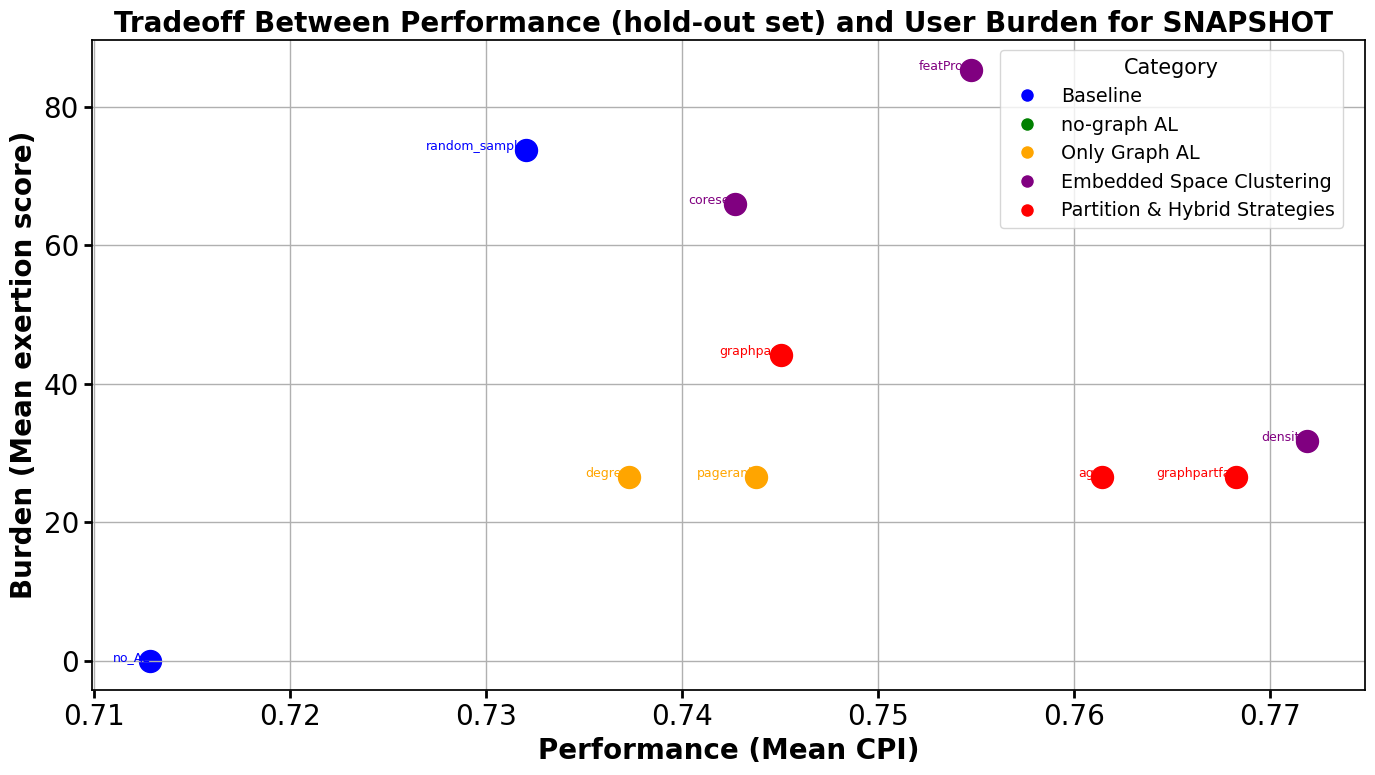

In [ ]:
# Define categories and their strategies
categories = {
    "Baseline": ['no_AL', 'random_sample'],
    "no-graph AL": [ 'uncertainty'],
    "Only Graph AL": ['pagerank', 'degree'],
    "Embedded Space Clustering": ['density', 'coreset', 'featProp'],
    "Partition & Hybrid Strategies": ['graphpart', 'graphpartfar','age']  # Example names; replace with actual strategies
}

# Define a color map for categories
category_colors = {
    "Baseline": 'blue',
    "no-graph AL": 'green',
    "Only Graph AL": 'orange',
    "Embedded Space Clustering": 'purple',
    "Partition & Hybrid Strategies": 'red',
}

# Define x (performance) and y (burden) metrics
x = merged_df['mean_CPI']  # Performance metric
y = merged_df['mean_over_exertion']  # Burden metric (can change to mean_avg_time_gap or mean_over_exertion)

# Plot the tradeoff between performance and burden
plt.figure(figsize=(14, 8))
for i, strategy in enumerate(merged_df['strategy']):
    # Determine the color for the strategy based on its category
    strategy_color = None
    for category, strategies in categories.items():
        if strategy in strategies:
            strategy_color = category_colors[category]
            break
    # Fallback color if strategy doesn't match any category
    if not strategy_color:
        strategy_color = 'gray'
    
    plt.scatter(x[i], y[i], label=strategy, color=strategy_color, s=250)
    plt.text(x[i], y[i], strategy, fontsize=9, ha='right', color=strategy_color)

plt.xlabel('Performance (Mean CPI)',weight="bold",fontsize=20)
plt.ylabel('Burden (Mean exertion score)',weight="bold",fontsize=20)
plt.title('Tradeoff Between Performance (hold-out set) and User Burden for SNAPSHOT ',weight="bold",fontsize=20)

# Increase font size and thickness of x and y ticks
plt.tick_params(axis='x', labelsize=20, width=2, length=6)  # Adjust x-axis tick size and thickness
plt.tick_params(axis='y', labelsize=20, width=2, length=6)  # Adjust y-axis tick size and thickness

# Customize legend for categories
handles = [plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=10) 
           for category, color in category_colors.items()]
plt.legend(handles=handles, title='Category', loc='upper right', bbox_to_anchor=(0.99, 1))

plt.grid(True)
plt.tight_layout()
plt.show()
